In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

def read_logic_analyzer_data(file_path):
    """
    Reads logic analyzer data from a CSV file.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The data from the CSV file as a DataFrame.
    """
    try:
        data = pd.read_csv(file_path)
        return data
    except Exception as e:
        print(f"Error reading the file: {e}")
        return None

def calculate_switch_times(data, filterTime = 0.0009, time_limit = 10):
    switch_times = []
    active_thread = -1
    last_active_time = 0

    for data_row in data.itertuples(index=False):
        if data_row[0] > time_limit:
            break
        if active_thread == -1:
            for channel in range(1, len(data_row)):
                if data_row[channel]:
                    switch_times.append(data_row[0] - last_active_time)
                    active_thread = channel
                    last_active_time = data_row[0]
                    break
        else:
            if not data_row[active_thread]:
                active_thread = -1
                last_active_time = data_row[0]
    
    filtered_switch_times = [time for time in switch_times[1:] if time <= filterTime]
    return filtered_switch_times 

def plot_time_histogram(switch_times, time_limit = 10):
    # Convert filtered switch times to microseconds
    switch_times = [time * 1e6 for time in switch_times]

    # Plot histogram of filtered switch times
    plt.figure(figsize=(6, 6))
    bin_width = 0.25  # microseconds
    bins = int((max(switch_times) - min(switch_times)) / bin_width)
    plt.hist(switch_times, bins=bins, edgecolor='black')
    plt.xlabel('Switch Time (µs)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Filtered Switch Times')
    plt.grid(True)
    plt.show()

def calculate_overhead(switch_times):
    best_case = min(switch_times)
    worst_case = max(switch_times)
    mean_case = sum(switch_times) / len(switch_times)
    median_case = switch_times[len(switch_times) // 2]

    return best_case, worst_case, mean_case, median_case

def print_overhead(best_case, worst_case, mean_case, median_case, hyperperiod, switchs_per_hyperperiod):
    print (f"Hyperperiod: {hyperperiod}")
    print (f"Switches per hyperperiod: {switchs_per_hyperperiod}")

    print (f"====================")
    print (f"Best case switch time: {best_case * 1e6:.2f} µs")
    print (f"Worst case switch time: {worst_case * 1e6:.2f} µs")
    print (f"Mean case switch time: {mean_case * 1e6:.2f} µs")
    print (f"Median case switch time: {median_case * 1e6:.2f} µs")
    print (f"====================")

    print (f"Best case overhead: {best_case * switchs_per_hyperperiod / hyperperiod * 100:.2f}%")
    print (f"Worst case overhead: {worst_case * switchs_per_hyperperiod/ hyperperiod * 100:.2f}%")
    print (f"Mean case overhead: {mean_case * switchs_per_hyperperiod / hyperperiod * 100:.2f}%")
    print (f"Median case overhead: {median_case *switchs_per_hyperperiod / hyperperiod * 100:.2f}%")

def analyze_switch_times(file_path, hyperperiod, switches_per_hyperperiod):
    data = read_logic_analyzer_data(file_path)
    switch_times = calculate_switch_times(data)
    plot_time_histogram(switch_times)
    best_case, worst_case, mean_case, median_case = calculate_overhead(switch_times)
    print_overhead(best_case, worst_case, mean_case, median_case, hyperperiod, switches_per_hyperperiod)


In [34]:
def plot_multiple_histograms(switch_times_list, labels, time_limit=10):
    plt.figure(figsize=(12, 8))
    bin_width = 0.25  # microseconds

    for switch_times, label in zip(switch_times_list, labels):
        # Convert switch times to microseconds
        switch_times = [time * 1e6 for time in switch_times]
        bins = int((max(switch_times) - min(switch_times)) / bin_width)
        plt.hist(switch_times, bins=bins, alpha=0.5, label=label, edgecolor='black')

    plt.xlabel('Switch Time (µs)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Filtered Switch Times from Multiple Datasets')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_multiple_histograms_datasets(datasets, time_limit=10):
    plt.figure(figsize=(12, 8))
    bin_width = 0.25  # microseconds

    for ds in datasets:
        # Convert switch times to microseconds
        switch_times = [time * 1e6 for time in ds.switch_times]
        bins = int((max(switch_times) - min(switch_times)) / bin_width)
        plt.hist(switch_times, bins=bins, alpha=0.5, label=ds.name, edgecolor='black')

    plt.xlabel('Switch Time (µs)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Filtered Switch Times from Multiple Datasets')
    plt.legend()
    plt.grid(True)
    plt.show()

class Task :
    def __init__(self, computation_time, period , deadline = 0):
        self.period = period
        if deadline == 0:
            self.deadline = period
        else:
            self.deadline = deadline
        self.computation_time = computation_time

    def __str__(self):
        return f"Period: {self.period}, Deadline: {self.deadline}, Computation Time: {self.computation_time}"

    def __repr__(self):
        return f"Period: {self.period}, Deadline: {self.deadline}, Computation Time: {self.computation_time}"

def Init_Task_Set_1():
    return [
        Task(2,20),
        Task(10,40),
        Task(30,60)
    ]

def Init_Task_Set_2():
    return [
        Task(10,20),
        Task(10,30),
        Task(10,60)
    ]

def Init_Task_Set_3():
    return [
        Task(10,20),
        Task(10,30),
        Task(15,60)
    ]



In [35]:
class DataSet:
    def __init__(self, file_path, hyperperiod, switches_per_hyperperiod, taskset = None, start_delay = 0, start_delay_index = 0, has_deadline_misses_channel = False):
        self.file_path = file_path
        self.name = file_path.split('/')[-2]
        self.hyperperiod = hyperperiod
        self.switches_per_hyperperiod = switches_per_hyperperiod
        self.taskset = taskset
        self.start_delay = start_delay
        self.start_delay_index = start_delay_index
        self.has_deadline_misses_channel = has_deadline_misses_channel

    def modelSystem(self):
        self.data = read_logic_analyzer_data(self.file_path)
        if self.start_delay_index:
            self.start_delay = self.data.iloc[self.start_delay_index][0]

        self.switch_times = calculate_switch_times(self.data)
        self.best_case, self.worst_case, self.mean_case, self.median_case = calculate_overhead(self.switch_times)

    def compare(self, other):
        best_case_diff = self.best_case - other.best_case
        worst_case_diff = self.worst_case - other.worst_case
        mean_case_diff = self.mean_case - other.mean_case
        median_case_diff = self.median_case - other.median_case
        return best_case_diff, worst_case_diff, mean_case_diff, median_case_diff
    def compare_hyper_period(self, other): 
        common_hyperperiod = self.hyperperiod / other.hyperperiod
        switch_times_1 = self.switches_per_hyperperiod
        switch_times_2 = other.switches_per_hyperperiod
        if common_hyperperiod != 1:
            # self.hyperperiod * w1 = other.hyperperiod * w2 = n
            int_hyperperiod = int(self.hyperperiod * 1000)
            int_other_hyperperiod = int(other.hyperperiod * 1000)
            n = 1
            while True:
                if int_hyperperiod % n == 0 and int_other_hyperperiod% n == 0:
                    int_other_hyperperiod = n
                    break

            w1 = float(n)/float(int_hyperperiod)
            w2 = float(n)/float(int_other_hyperperiod)
            common_hyperperiod = float(n) / 1000
            switch_times_1 = w1 * float(self.switches_per_hyperperiod)
            switch_times_2 = w2 * float(other.switches_per_hyperperiod)


        best_case_diff = self.best_case * switch_times_1 - other.best_case * switch_times_2 
        worst_case_diff = self.worst_case * switch_times_1  - other.worst_case * switch_times_2 
        mean_case_diff = self.mean_case * switch_times_1  - other.mean_case * switch_times_2 
        median_case_diff = self.median_case * switch_times_1   - other.median_case * switch_times_2 

        return best_case_diff, worst_case_diff, mean_case_diff, median_case_diff

    def print_overhead(self):
        print_overhead(self.best_case, self.worst_case, self.mean_case, self.median_case, self.hyperperiod, self.switches_per_hyperperiod)
    
    def print_compared_overhead(self, other = None):
        print(f"Comparing overheads of {self.name} and {other.name}\n")

        print(f"Overhead for {self.name}:")
        self.print_overhead()
        print()

        print(f"Overhead for {other.name}:")
        other.print_overhead()
        print() 
        
        best_case_diff, worst_case_diff, mean_case_diff, median_case_diff = self.compare(other)
        print("Difference in overheads:")
        print(f"Best case switch time difference: {best_case_diff * 1e6:.2f} µs")
        print(f"Worst case switch time difference: {worst_case_diff * 1e6:.2f} µs")
        print(f"Mean case switch time difference: {mean_case_diff * 1e6:.2f} µs")
        print(f"Median case switch time difference: {median_case_diff * 1e6:.2f} µs")
        print("=====================================")
        best_case_diff, worst_case_diff, mean_case_diff, median_case_diff = self.compare_hyper_period(other)
        print("Difference in overheads with respect to hyperperiod:")
        print(f"Best case switch time difference: {best_case_diff * 1e6:.2f} µs")
        print(f"Worst case switch time difference: {worst_case_diff * 1e6:.2f} µs")
        print(f"Mean case switch time difference: {mean_case_diff * 1e6:.2f} µs")
        print(f"Median case switch time difference: {median_case_diff * 1e6:.2f} µs")
    
    def plot_histogram(self):
        plot_time_histogram(self.switch_times)

    def plot_time_line(self, time_limit = 0, start_time = 0.0, show_deadline_misses = False):
        # plot time line based on data
        
        if time_limit == 0:
            time_limit = self.hyperperiod * 3

        plt.figure(figsize=(16, 1))
        rows =self.data.itertuples(index=False)
    
        # rows as list 
        rows = [row for row in rows]
        verts = []
        colours = []
        channels = len(rows[0])
        for row in range(0, len(rows)):
            data_row = rows[row]
            if data_row[0] -self.start_delay < start_time:
                continue
            if data_row[0] -self.start_delay > time_limit + start_time:
                break
            
            channels = len(data_row) 
            if self.has_deadline_misses_channel:
                channels -= 1
            
            for channel in range(1, channels):
                if data_row[channel]:
                    # plt.axvline(x=data_row[0]*1000, color='r', linestyle='--')
                    v = [
                        (1000*(data_row[0]-self.start_delay), channel-1),
                        (1000*(rows[row+1][0]-self.start_delay), channel-1),
                        (1000*(rows[row+1][0]-self.start_delay), channel-0.75),
                        (1000*(data_row[0]-self.start_delay), channel-0.75)
                    ]
                    verts.append(v)
                    colours.append('r')
                    break
            
        if show_deadline_misses and self.has_deadline_misses_channel:
            for row in range(0, len(rows)):
                data_row = rows[row]
                if data_row[0] -self.start_delay < start_time:
                    continue
                if data_row[0] -self.start_delay > time_limit + start_time:
                    break
                if data_row[-1]:
                    v = [
                        (1000*(data_row[0]-self.start_delay), channels+-1),
                        (1000*(rows[row+1][0]-self.start_delay), channels-1),
                        (1000*(rows[row+1][0]-self.start_delay), channels-0.75),
                        (1000*(data_row[0]-self.start_delay), channels-0.75)
                    ]
                    verts.append(v)
                    colours.append('r')
        

        bars = PolyCollection(verts, facecolors=colours)
        plt.gca().add_collection(bars)
                    
        task_start = int(start_time * 1000)
        #plot task set periods and deadlines
        if self.taskset:

            for t in range(0, len(self.taskset)):
                task = self.taskset[t]
                for i in range(int(task_start / task.period), int((start_time + time_limit) * 1000 / task.period)+1):
                    plt.plot([task.period* i, 
                              task.period * i], 
                             [t, t+0.5], 
                             color='b', 
                             linestyle='--')
                    
                    if task.period != task.deadline:
                        plt.plot([task.deadline + task.period * i,
                                  task.deadline + task.period * i], 
                                 [t, t+0.5], 
                                 color='b', 
                                 linestyle='--')
                
        plt.xlabel('Time (ms)')
        plt.ylabel('Thread')
        # only show int values
        if show_deadline_misses and self.has_deadline_misses_channel:
            plt.yticks(range(0, len(self.taskset)+1), range(0, len(self.taskset)+1))
        else:
            plt.yticks(range(0, len(self.taskset)), range(0, len(self.taskset)))
        
        # plot margins
        plt
        
        plt.title('Timeline of active threads')
        plt.grid(True)
        plt.show()
        
    
    def calculate_deadline_misses(self, time_limit = 10):
        # does not work well as 1 sec on board is not 1 sec in real time minor difference in time
        active_thread = -1
        activation_time_task = 0
        task_period_counter = [0] * len(self.taskset)
        task_deadline_misses = [0] * len(self.taskset)
        task_execution_accumulation = [0] * len(self.taskset)

        rows =self.data.itertuples(index=False)
        rows = [row for row in rows]

        for row in range(0, len(rows)):
            if row < self.start_delay_index:
                continue
            
            data_row = rows[row]
            
            if data_row[0] > time_limit + self.start_delay:
                break
            
            time = data_row[0] - self.start_delay
            # check which thread became active
            if active_thread == -1:
                for channel in range(1, len(data_row)):
                    if data_row[channel]:
                        active_thread = channel -1
                        activation_time_task = time
                        break
            else:
                if not data_row[active_thread+1]:
                    # check if deadline is missed
                    
                    task = self.taskset[active_thread]
                    task_execution_ms = (time-activation_time_task) *1000
                    completion = task_execution_accumulation[active_thread] + task_execution_ms - task.computation_time
                    if completion > -2.5e-2:
                        abs_deadline = (task_period_counter[active_thread]*task.period) + task.deadline
                        remaining_time = abs_deadline - time * 1000
                        if remaining_time < 0:
                            task_deadline_misses[active_thread] += 1
                        
                        task_period_counter[active_thread] += 1
                        task_execution_accumulation[active_thread] = 0
                    else:
                        task_execution_accumulation[active_thread] += task_execution_ms
                        
                    active_thread = -1
        return task_deadline_misses
                        
                        
def analyze_dataset(dataset):
    dataset.modelSystem()
    dataset.plot_time_line(dataset.hyperperiod*2)
    dataset.print_overhead()
    dataset.plot_histogram()
    # misses =  dataset.calculate_deadline_misses()
    # print(f"Deadline misses: {misses}")
    # print(f"Total deadline misses: {sum(misses)}")              

/tmp/ipykernel_40998/710686937.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.start_delay = self.data.iloc[self.start_delay_index][0]


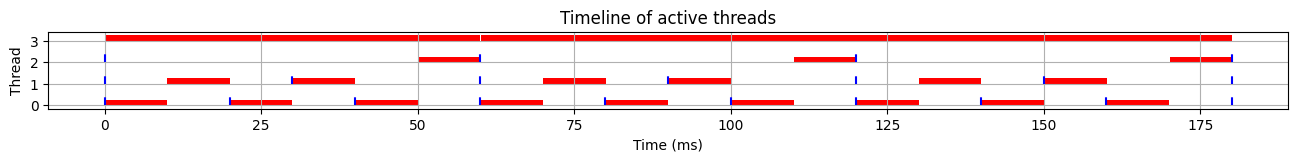

In [36]:
dataset_rm_t2 = DataSet('./datasets/RMdatasetTaskSet3DM/digital.csv', 0.060, 6, Init_Task_Set_3(), start_delay_index=20, has_deadline_misses_channel=True) #17
dataset = dataset_rm_t2
dataset.modelSystem()
dataset.plot_time_line(0.060*3, show_deadline_misses=True)


/tmp/ipykernel_40998/710686937.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.start_delay = self.data.iloc[self.start_delay_index][0]


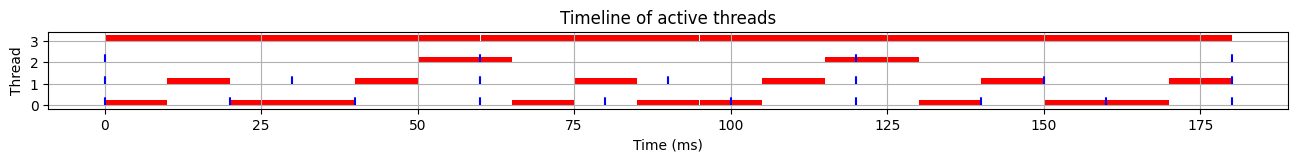

In [37]:
dataset_rm_t2 = DataSet('./datasets/EDFdatasetTaskSet3DM/digital.csv', 0.060, 6, Init_Task_Set_3(), start_delay_index=35, has_deadline_misses_channel=True) #17
dataset = dataset_rm_t2
dataset.modelSystem()
dataset.plot_time_line(0.060*3, show_deadline_misses=True)


/tmp/ipykernel_40998/710686937.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.start_delay = self.data.iloc[self.start_delay_index][0]


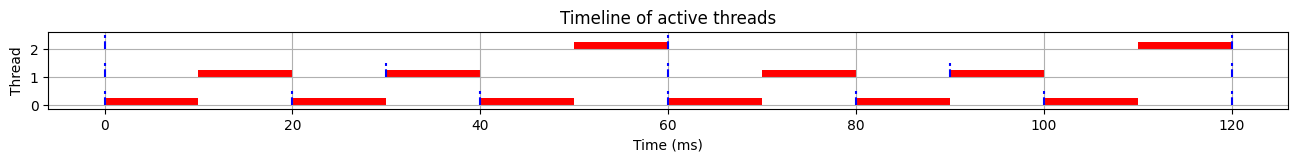

Hyperperiod: 0.06
Switches per hyperperiod: 6
Best case switch time: 22.00 µs
Worst case switch time: 26.00 µs
Mean case switch time: 22.40 µs
Median case switch time: 22.00 µs
Best case overhead: 0.22%
Worst case overhead: 0.26%
Mean case overhead: 0.22%
Median case overhead: 0.22%


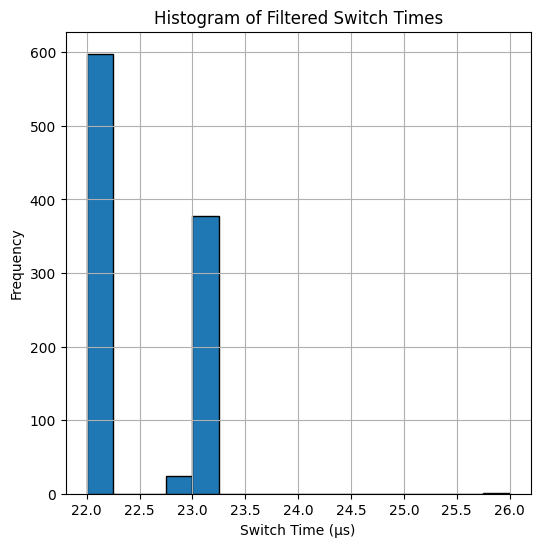

In [38]:
dataset_rm_t2 = DataSet('./datasets/RMdatasetTaskSet2/digital.csv', 0.060, 6, Init_Task_Set_2(), start_delay_index=6*2) #17
analyze_dataset(dataset_rm_t2)

/tmp/ipykernel_40998/710686937.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.start_delay = self.data.iloc[self.start_delay_index][0]


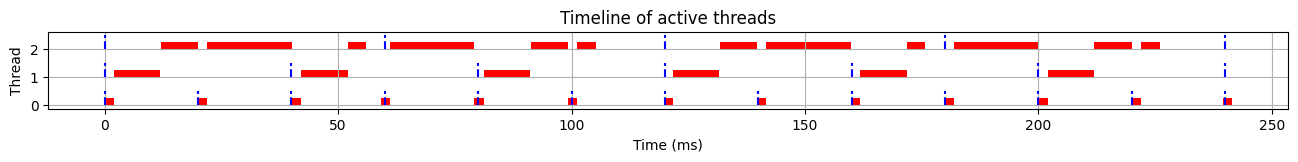

Hyperperiod: 0.12
Switches per hyperperiod: 35
Best case switch time: 15.00 µs
Worst case switch time: 27.00 µs
Mean case switch time: 21.43 µs
Median case switch time: 16.00 µs
Best case overhead: 0.44%
Worst case overhead: 0.79%
Mean case overhead: 0.63%
Median case overhead: 0.47%


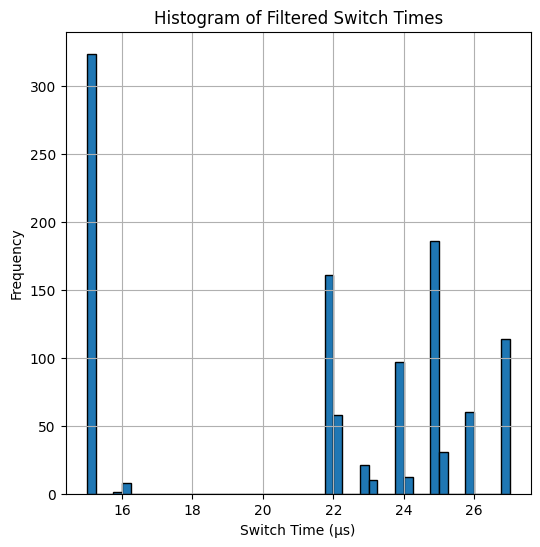

In [39]:
# when no task selected delay is equal to 1 ms
dataset_1 = DataSet('./datasets/RMdataset1/digital.csv', 0.120, 17 + 4 +14, Init_Task_Set_1(), start_delay_index=1)
analyze_dataset(dataset_1)




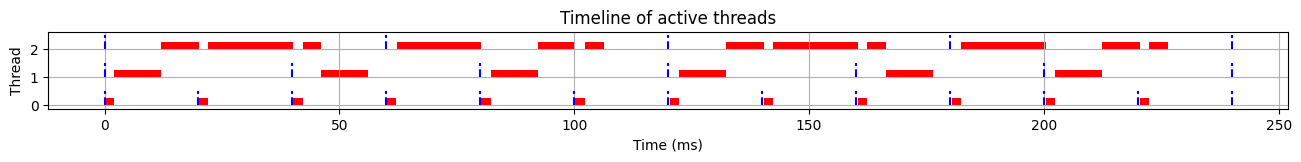

Hyperperiod: 0.12
Switches per hyperperiod: 35
Best case switch time: 15.00 µs
Worst case switch time: 27.00 µs
Mean case switch time: 21.65 µs
Median case switch time: 15.00 µs
Best case overhead: 0.44%
Worst case overhead: 0.79%
Mean case overhead: 0.63%
Median case overhead: 0.44%


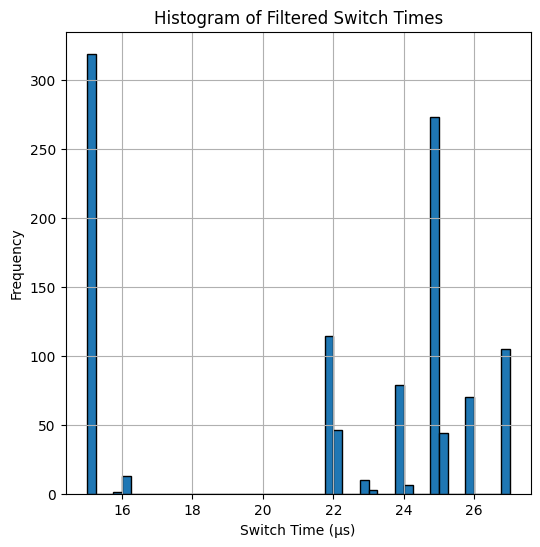

In [40]:
# when no task selected delay is equal to 1 ms

dataset_3 = DataSet('./datasets/EDFdataset2/digital.csv', 0.120, 17 + 4 + 14, Init_Task_Set_1()) #17
analyze_dataset(dataset_3)


Comparing overheads of RMdataset1 and EDFdataset2

Overhead for RMdataset1:
Hyperperiod: 0.12
Switches per hyperperiod: 35
Best case switch time: 15.00 µs
Worst case switch time: 27.00 µs
Mean case switch time: 21.43 µs
Median case switch time: 16.00 µs
Best case overhead: 0.44%
Worst case overhead: 0.79%
Mean case overhead: 0.63%
Median case overhead: 0.47%

Overhead for EDFdataset2:
Hyperperiod: 0.12
Switches per hyperperiod: 35
Best case switch time: 15.00 µs
Worst case switch time: 27.00 µs
Mean case switch time: 21.65 µs
Median case switch time: 15.00 µs
Best case overhead: 0.44%
Worst case overhead: 0.79%
Mean case overhead: 0.63%
Median case overhead: 0.44%

Difference in overheads:
Best case switch time difference: 0.00 µs
Worst case switch time difference: 0.00 µs
Mean case switch time difference: -0.22 µs
Median case switch time difference: 1.00 µs
Difference in overheads with respect to hyperperiod:
Best case switch time difference: 0.00 µs
Worst case switch time difference:

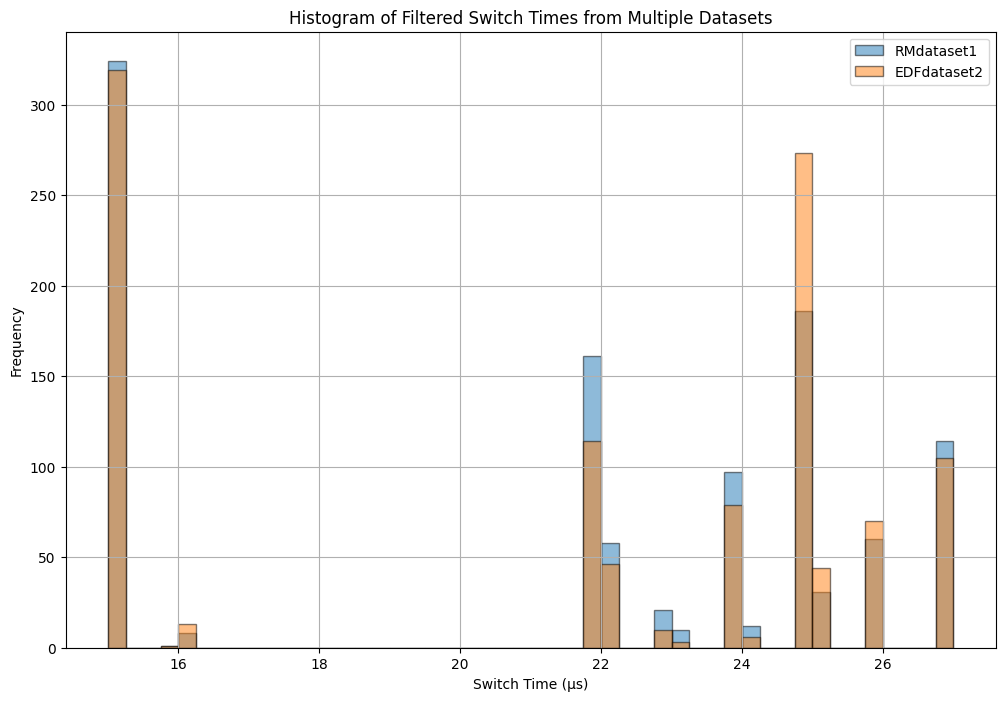

In [41]:
dataset_1.print_compared_overhead(dataset_3)

plot_multiple_histograms_datasets([dataset_1, dataset_3])

/tmp/ipykernel_40998/710686937.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.start_delay = self.data.iloc[self.start_delay_index][0]


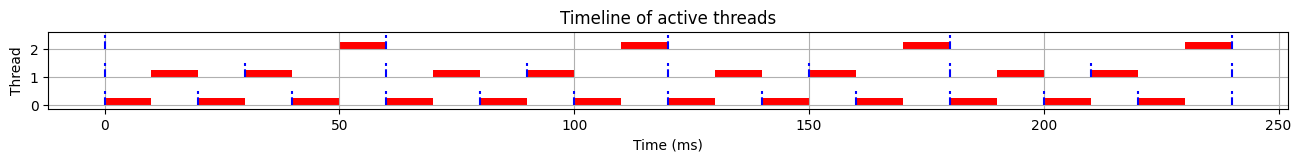

Hyperperiod: 0.12
Switches per hyperperiod: 6
Best case switch time: 22.00 µs
Worst case switch time: 26.00 µs
Mean case switch time: 22.40 µs
Median case switch time: 22.00 µs
Best case overhead: 0.11%
Worst case overhead: 0.13%
Mean case overhead: 0.11%
Median case overhead: 0.11%


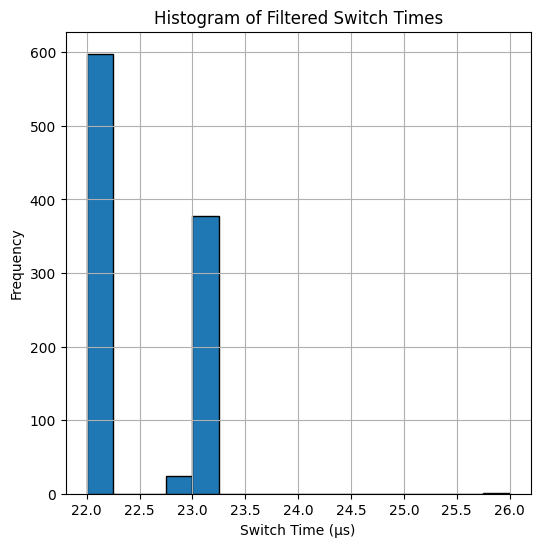

In [42]:
dataset_rm_t2 = DataSet('./datasets/RMdatasetTaskSet2/digital.csv', 0.120, 6, Init_Task_Set_2(), start_delay_index=12) #17
analyze_dataset(dataset_rm_t2)

/tmp/ipykernel_40998/710686937.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.start_delay = self.data.iloc[self.start_delay_index][0]


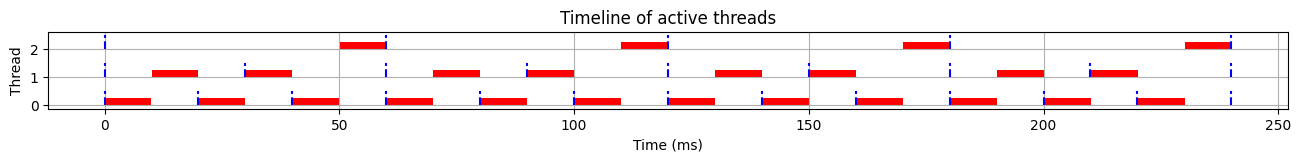

Hyperperiod: 0.12
Switches per hyperperiod: 6
Best case switch time: 14.00 µs
Worst case switch time: 29.00 µs
Mean case switch time: 22.21 µs
Median case switch time: 25.00 µs
Best case overhead: 0.07%
Worst case overhead: 0.15%
Mean case overhead: 0.11%
Median case overhead: 0.12%


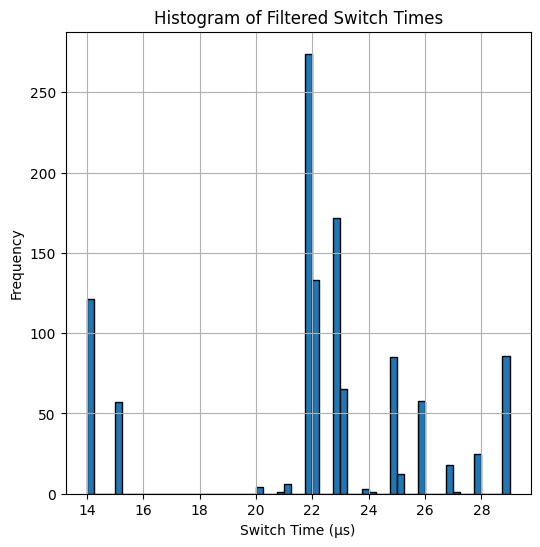

In [43]:
dataset_rm_t2 = DataSet('./datasets/RMdatasetTaskSet3/digital.csv', 0.120, 6, Init_Task_Set_3(), start_delay_index=13) #17
analyze_dataset(dataset_rm_t2)

/tmp/ipykernel_40998/710686937.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.start_delay = self.data.iloc[self.start_delay_index][0]


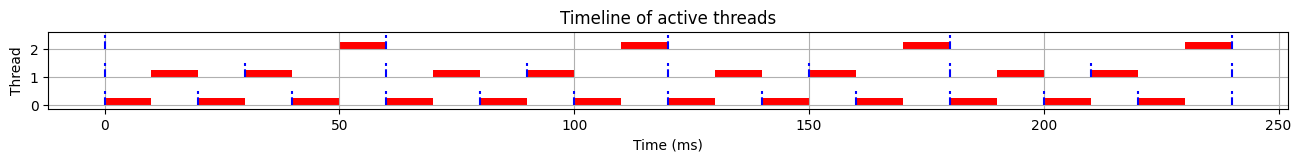

Hyperperiod: 0.12
Switches per hyperperiod: 6
Best case switch time: 22.00 µs
Worst case switch time: 23.00 µs
Mean case switch time: 22.36 µs
Median case switch time: 22.00 µs
Best case overhead: 0.11%
Worst case overhead: 0.12%
Mean case overhead: 0.11%
Median case overhead: 0.11%


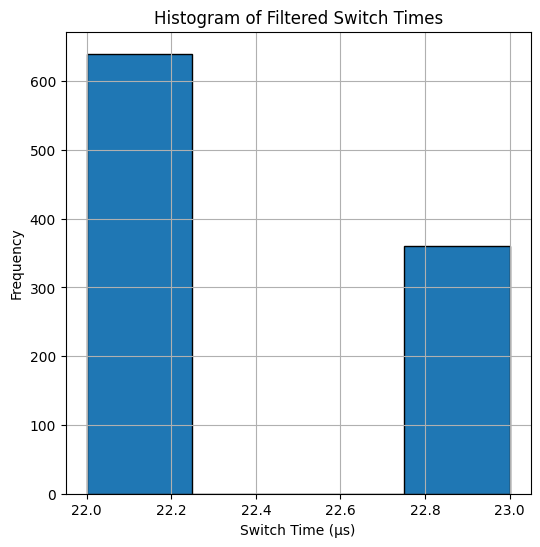

In [44]:
dataset_rm_t2 = DataSet('./datasets/EDFdatasetTaskSet2/digital.csv', 0.120, 6, Init_Task_Set_2(), start_delay_index=12) #17
analyze_dataset(dataset_rm_t2)

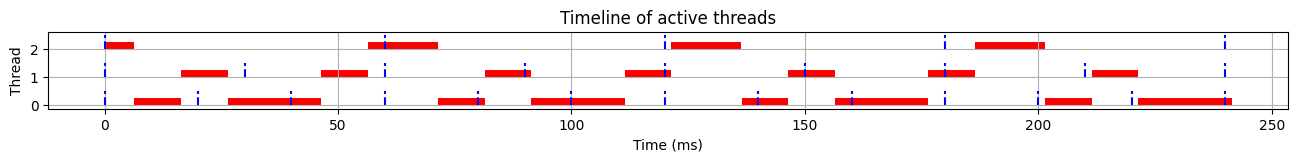

Hyperperiod: 0.12
Switches per hyperperiod: 6
Best case switch time: 16.00 µs
Worst case switch time: 27.00 µs
Mean case switch time: 22.47 µs
Median case switch time: 27.00 µs
Best case overhead: 0.08%
Worst case overhead: 0.14%
Mean case overhead: 0.11%
Median case overhead: 0.14%


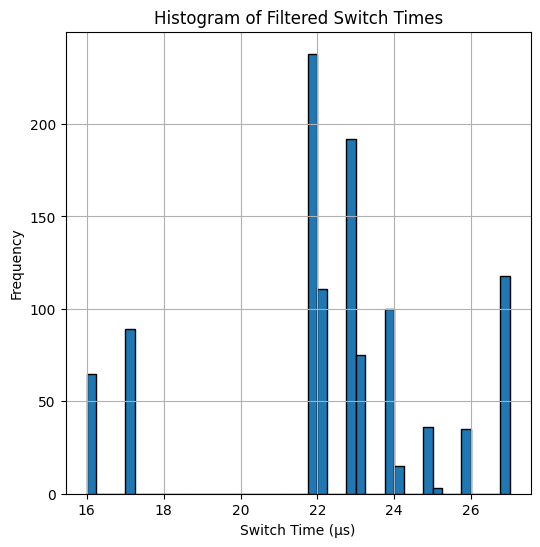

In [45]:
dataset_rm_t2 = DataSet('./datasets/EDFdatasetTaskSet3/digital.csv', 0.120, 6, Init_Task_Set_3(), start_delay_index=0) #17
analyze_dataset(dataset_rm_t2)